In [1]:
import copy
import os
import math
import sys

import numpy as np
import yaml

import torch
import torch.nn as nn
import torch.nn.functional as F

sys.path.append('../')
from slow_reservoir.model import RNN
from slow_reservoir.dataset.dynamic_state import State

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
sigma_sq = 0.5

In [108]:
def make_signal_for_prior(time_length, mu_p, sigma_p, uncertainty=0.5, g=2):
    input_signals = np.zeros([1, time_length, 100])
    phi = np.linspace(-2, 2, 100)
    
    state = State(mu=mu_p, sigma=sigma_p)
    
    for i in range(1):
        signal_input = np.zeros([time_length, 100])
        for t in range(time_length):
            true_signal = state()
            signal_sigma = np.sqrt(1 / g) * uncertainty
            signal_mu = np.random.normal(true_signal, signal_sigma)
            
            signal_base = g * np.exp(-(signal_mu - phi) ** 2 / (2.0 * sigma_sq))
            signal_input[t] = np.random.poisson(signal_base)
        
        input_signals[i] = signal_input
        
    return input_signals


def make_sample_signal(g=2):
    input_signals = np.zeros([21, 4, 100])
    phi = np.linspace(-2, 2, 100)
    
    for i, signal_mu in enumerate(np.linspace(-0.5, 0.5, 21)):
        signal_base = g * np.exp(-(signal_mu - phi) ** 2 / (2.0 * sigma_sq))
        for t in range(4):
            input_signals[i, t] = np.random.poisson(signal_base)
        
    return input_signals

In [109]:
config_path = '../slow_reservoir/trained_model/dynamic_state_random/20220428_4/20220428_4.cfg'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)
    

model_name = os.path.splitext(os.path.basename(config_path))[0]
print('model_name: ', model_name)

torch.manual_seed(1)
device = torch.device('cpu')

model = RNN(
        n_in=cfg['DATALOADER']['INPUT_NEURON'],
        n_out=1,
        n_hid=cfg['MODEL']['SIZE'],
        n_reservoir=cfg['MODEL']['RESERVOIR'],
        device=device,
        alpha_fast=cfg['MODEL']['ALPHA_FAST'],
        alpha_slow=cfg['MODEL']['ALPHA_SLOW'],
        sigma_neu=cfg['MODEL']['SIGMA_NEU'],
    ).to(device)

model_path = f'../slow_reservoir/trained_model/dynamic_state_random/{model_name}/epoch_500.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()



model_name:  20220428_4


RNN(
  (w_in): Linear(in_features=100, out_features=200, bias=True)
  (w_hh): Linear(in_features=200, out_features=200, bias=True)
  (w_out): Linear(in_features=200, out_features=1, bias=True)
  (w_fs): Linear(in_features=200, out_features=50, bias=True)
  (w_sf): Linear(in_features=50, out_features=200, bias=True)
  (w_reservoir): Linear(in_features=50, out_features=50, bias=True)
  (w_prior): Linear(in_features=50, out_features=100, bias=True)
)

In [110]:
np.linspace(-0.5, 0.5, 21)

array([-0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15, -0.1 ,
       -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,
        0.4 ,  0.45,  0.5 ])

In [111]:
main_network_dynamics = np.zeros((21, 21, 200))
sub_network_dynamics = np.zeros((21, 21, 50))

In [131]:
sigma_p = 0.2
sigma_l = math.sqrt(1/1) * 0.5
g = 1 / (4 * sigma_l)

sample_signal = make_sample_signal(g=g)

for i, mu_p in enumerate(np.linspace(-0.5, 0.5, 21)):
    input_signal = make_signal_for_prior(
        time_length=50, 
        mu_p=mu_p,
        sigma_p=sigma_p,
        uncertainty=0.5,
        g=g,
    )
    inputs = torch.from_numpy(input_signal).float()                                 
    inputs = inputs.to(device) 
    hidden_np = np.random.normal(0, 0.5, size=(1, cfg['MODEL']['SIZE']))
    reservoir_np = np.random.normal(0, 0.5, size=(1, cfg['MODEL']['RESERVOIR']))
         
    hidden = torch.from_numpy(hidden_np).float()                               
    hidden = hidden.to(device) 
    reservoir = torch.from_numpy(reservoir_np).float()
    reservoir = reservoir.to(device)
    hidden_list, _, _, reservoir_list = model(inputs, hidden, reservoir, 50) 
    
    neural_dynamics = hidden_list.cpu().detach().numpy()   
    reservoir_dynamics = reservoir_list.cpu().detach().numpy()
    
    initial_state = copy.deepcopy(neural_dynamics[0, -1])
    initial_res_state = copy.deepcopy(reservoir_dynamics[0, -1])

    hidden_np = initial_state
    hidden = torch.from_numpy(hidden_np).float()                               
    hidden = hidden.to(device)                                                   
    reservoir_np = initial_res_state
    reservoir = torch.from_numpy(reservoir_np).float()
    reservoir = reservoir.to(device)
    
    inputs = torch.from_numpy(sample_signal).float()                                 
    inputs = inputs.to(device)                                                      
    
    hidden_list, output_list, _, reservoir_list = model(inputs, hidden, reservoir, 2)

    main_network_dynamics[i] = hidden_list.detach().numpy()[:, -1]
    sub_network_dynamics[i] = reservoir_list.detach().numpy()[:, -1]


In [132]:
np.mean(np.var(main_network_dynamics[:, :, 3], axis=0))

0.010845666480163317

In [133]:
np.mean(np.var(main_network_dynamics[:, :, 3], axis=1))

0.011028483304875375

In [134]:
np.mean(np.var(main_network_dynamics[:, :, 18], axis=0))

0.009410499346846004

In [135]:
np.mean(np.var(main_network_dynamics[:, :, 18], axis=1))

0.009466949933869253

In [136]:
np.mean(np.var(sub_network_dynamics[:, :, 1], axis=0))

0.04268911960974259

In [137]:
np.mean(np.var(sub_network_dynamics[:, :, 1], axis=1))

0.00019117717670001644

In [138]:
np.mean(np.var(sub_network_dynamics[:, :, 5], axis=1))

0.00022631639709609028

In [139]:
np.mean(np.var(main_network_dynamics[:, :, 6], axis=1))

0.058142312740694445

In [140]:
np.mean(np.var(main_network_dynamics[:, :, 6], axis=0))

0.2148937804152978

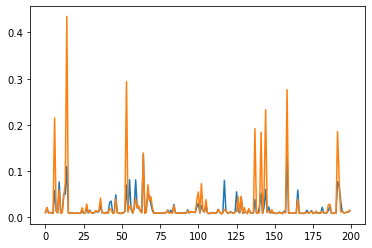

In [141]:
plt.plot(np.mean(np.var(main_network_dynamics[:, :, :], axis=1), axis=0))
plt.plot(np.mean(np.var(main_network_dynamics[:, :, :], axis=0), axis=0))

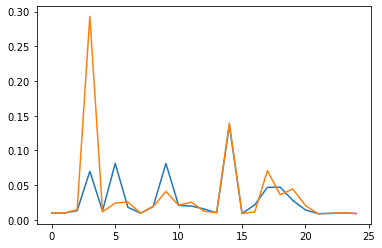

In [142]:
plt.plot(np.mean(np.var(main_network_dynamics[:, :, 50:75], axis=1), axis=0))
plt.plot(np.mean(np.var(main_network_dynamics[:, :, 50:75], axis=0), axis=0))

In [143]:
likelihood_variance = np.mean(np.var(main_network_dynamics[:, :, :], axis=1), axis=0)
prior_variance = np.mean(np.var(main_network_dynamics[:, :, :], axis=0), axis=0)

In [144]:
role_of_neurons = {}
likelihood_neurons = []
prior_neurons = []
for i in range(likelihood_variance.shape[0]):
    if max(likelihood_variance[i], prior_variance[i]) > 0.0:
        role_of_neurons[i] = likelihood_variance[i] / prior_variance[i]
        if likelihood_variance[i] / prior_variance[i] > 1.5:
            likelihood_neurons.append(i)
        elif likelihood_variance[i] / prior_variance[i] <= 0.6:
            prior_neurons.append(i)

In [145]:
role_of_neurons

{0: 0.9838964412768116,
 1: 0.9728897436247947,
 2: 1.0507368406265583,
 3: 1.016856209348354,
 4: 1.029837322079948,
 5: 0.9736158095987629,
 6: 0.27056303178402935,
 7: 1.0907596096383434,
 8: 1.0013744989622808,
 9: 1.2878158137610582,
 10: 1.0021941669834065,
 11: 1.2634623907757494,
 12: 1.1239975507415658,
 13: 0.6619780789428126,
 14: 0.2535622853344886,
 15: 0.9938240312535589,
 16: 1.015247293083778,
 17: 0.9579955779089332,
 18: 1.0059986813603221,
 19: 1.0254904933035822,
 20: 1.0154281676447534,
 21: 0.9940992404832537,
 22: 0.9892546297928329,
 23: 0.997241416660098,
 24: 0.6162512818989182,
 25: 0.9920125389103426,
 26: 1.0131164733943847,
 27: 0.6546267459810233,
 28: 0.9808498749698373,
 29: 1.0912919954728098,
 30: 0.9777422941651764,
 31: 1.0051161286970962,
 32: 1.0238974925895985,
 33: 0.9494797564240544,
 34: 0.9216797668981099,
 35: 0.9084629106967465,
 36: 0.6121694356254408,
 37: 1.0189003605591758,
 38: 1.0099502965080172,
 39: 0.9947950710580182,
 40: 1.013375

`role of neurons`が1以上だとlikelihoodへの反応性が大きい。1未満だとpriorへの反応性が大きい

In [146]:
role_of_neurons

{0: 0.9838964412768116,
 1: 0.9728897436247947,
 2: 1.0507368406265583,
 3: 1.016856209348354,
 4: 1.029837322079948,
 5: 0.9736158095987629,
 6: 0.27056303178402935,
 7: 1.0907596096383434,
 8: 1.0013744989622808,
 9: 1.2878158137610582,
 10: 1.0021941669834065,
 11: 1.2634623907757494,
 12: 1.1239975507415658,
 13: 0.6619780789428126,
 14: 0.2535622853344886,
 15: 0.9938240312535589,
 16: 1.015247293083778,
 17: 0.9579955779089332,
 18: 1.0059986813603221,
 19: 1.0254904933035822,
 20: 1.0154281676447534,
 21: 0.9940992404832537,
 22: 0.9892546297928329,
 23: 0.997241416660098,
 24: 0.6162512818989182,
 25: 0.9920125389103426,
 26: 1.0131164733943847,
 27: 0.6546267459810233,
 28: 0.9808498749698373,
 29: 1.0912919954728098,
 30: 0.9777422941651764,
 31: 1.0051161286970962,
 32: 1.0238974925895985,
 33: 0.9494797564240544,
 34: 0.9216797668981099,
 35: 0.9084629106967465,
 36: 0.6121694356254408,
 37: 1.0189003605591758,
 38: 1.0099502965080172,
 39: 0.9947950710580182,
 40: 1.013375

In [147]:
np.mean(np.var(main_network_dynamics[:, :, 55], axis=0))

0.024155091192327414

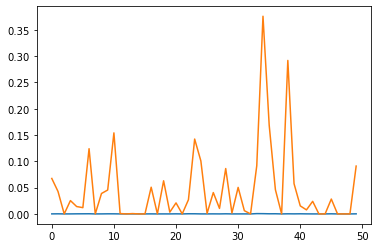

In [148]:
plt.plot(np.mean(np.var(sub_network_dynamics[:, :, :], axis=1), axis=0))
plt.plot(np.mean(np.var(sub_network_dynamics[:, :, :], axis=0), axis=0))

In [149]:
print(np.sum(abs(model.w_in.weight.detach().numpy()[137, :])))
print(np.sum((model.w_in.weight.detach().numpy()[137, :])))

4.273729
3.58982


In [150]:
print(np.sum(abs(model.w_in.weight.detach().numpy()[55, :])))
print(np.sum((model.w_in.weight.detach().numpy()[55, :])))

5.6552186
-1.7750611


In [151]:
print(np.sum(abs(model.w_in.weight.detach().numpy()[14, :])))
print(np.sum((model.w_in.weight.detach().numpy()[14, :])))

3.6796975
-1.392473


In [152]:
print(np.sum(abs(model.w_in.weight.detach().numpy()[117, :])))
print(np.sum((model.w_in.weight.detach().numpy()[117, :])))

5.178076
-2.0708456


In [153]:
print(np.sum(abs(model.w_fs.weight.detach().numpy()[:, 137])))
print(np.sum((model.w_fs.weight.detach().numpy()[:, 137])))

2.8054883
1.9260342


In [154]:
print(np.sum(abs(model.w_fs.weight.detach().numpy()[:, 55])))
print(np.sum((model.w_fs.weight.detach().numpy()[:, 55])))

1.2992064
0.3443804


In [155]:
print(np.sum(abs(model.w_fs.weight.detach().numpy()[:, 14])))
print(np.sum((model.w_fs.weight.detach().numpy()[:, 14])))

1.6584556
-0.39322472


In [156]:
print(np.sum(abs(model.w_fs.weight.detach().numpy()[:, 117])))
print(np.sum((model.w_fs.weight.detach().numpy()[:, 117])))

1.2024891
0.20560881


In [157]:
print(np.sum(abs(model.w_sf.weight.detach().numpy()[137, :])))
print(np.sum((model.w_sf.weight.detach().numpy()[137, :])))

1.8934437
1.2549578


In [158]:
print(np.sum(abs(model.w_sf.weight.detach().numpy()[55, :])))
print(np.sum((model.w_sf.weight.detach().numpy()[55, :])))

2.2782106
0.83159107


In [159]:
print(np.sum(abs(model.w_sf.weight.detach().numpy()[14, :])))
print(np.sum((model.w_sf.weight.detach().numpy()[14, :])))

2.0601017
0.5298339


In [160]:
print(np.sum(abs(model.w_sf.weight.detach().numpy()[117, :])))
print(np.sum((model.w_sf.weight.detach().numpy()[117, :])))

2.0447693
1.1913935


In [161]:
likelihood_variance[55]

0.08141691776984665

In [162]:
prior_variance[55]

0.02415509119232741

In [163]:
likelihood_variance[137]

0.03890148572508304

In [164]:
prior_variance[137]

0.19191890355447297

In [165]:
model.w_sf.weight.detach().numpy().shape

(200, 50)

In [166]:
likelihood_neurons

[42, 43, 55, 59, 66, 117, 125, 140, 146, 165, 181, 193]

In [167]:
prior_neurons

[6, 14, 53, 100, 102, 126, 130, 137, 141, 143, 144, 158, 185, 191]

In [168]:
w_in_weight = 0
count = 0
for idx in likelihood_neurons:
    w_in_weight += np.sum(abs(model.w_in.weight.detach().numpy()[idx, :]))
    count += 1
print(w_in_weight / count)

4.3827386399110155


In [169]:
w_in_weight = 0
count = 0
for idx in prior_neurons:
    w_in_weight += np.sum(abs(model.w_in.weight.detach().numpy()[idx, :]))
    count += 1
print(w_in_weight / count)

3.2045149207115173


In [170]:
w_fs_weight = 0
count = 0
for idx in likelihood_neurons:
    w_fs_weight += np.sum(abs(model.w_fs.weight.detach().numpy()[:, idx]))
    count += 1
print(w_fs_weight / count)

1.1052954147259395


In [171]:
w_fs_weight = 0
count = 0
for idx in prior_neurons:
    w_fs_weight += np.sum(abs(model.w_fs.weight.detach().numpy()[:, idx]))
    count += 1
print(w_fs_weight / count)

1.1960001268557139


In [172]:
w_sf_weight = 0
count = 0
for idx in likelihood_neurons:
    w_sf_weight += np.sum(abs(model.w_sf.weight.detach().numpy()[idx, :]))
    count += 1
print(w_sf_weight / count)

1.6539639631907146


In [173]:
w_sf_weight = 0
count = 0
for idx in prior_neurons:
    w_sf_weight += np.sum(abs(model.w_sf.weight.detach().numpy()[idx, :]))
    count += 1
print(w_sf_weight / count)

1.7363479392869132


In [174]:
sub_net_var = np.mean(np.var(sub_network_dynamics[:, :, :], axis=0), axis=0)


In [175]:
sub_net_var = np.mean(np.var(sub_network_dynamics[:, :, :], axis=0), axis=0)
sub_neurons = []
for i in range(len(sub_net_var)):
    if sub_net_var[i] > 0.1:
        sub_neurons.append(i)

In [176]:
sub_neurons

[6, 10, 23, 24, 34, 35, 38]

In [177]:
sub_net_var = np.mean(np.var(sub_network_dynamics[:, :, :], axis=0), axis=0)
sub_neurons = []
for i in range(len(sub_net_var)):
    if sub_net_var[i] > 0.2:
        sub_neurons.append(i)

In [178]:
sub_neurons

[34, 38]

In [179]:
w_fs_weight = 0
count = 0
for idx in likelihood_neurons:
    w_fs_weight += np.sum(abs(model.w_fs.weight.detach().numpy()[sub_neurons, idx]))
    count += 1
print(w_fs_weight / count)

0.05643692069376508


In [180]:
w_fs_weight = 0
count = 0
for idx in prior_neurons:
    w_fs_weight += np.sum(abs(model.w_fs.weight.detach().numpy()[sub_neurons, idx]))
    count += 1
print(w_fs_weight / count)

0.09728247865236231


In [181]:
w_sf_weight = 0
count = 0
for idx in likelihood_neurons:
    w_sf_weight += np.sum(abs(model.w_sf.weight.detach().numpy()[idx, sub_neurons]))
    count += 1
print(w_sf_weight / count)

0.09673761824766795


In [182]:
w_sf_weight = 0
count = 0
for idx in prior_neurons:
    w_sf_weight += np.sum(abs(model.w_sf.weight.detach().numpy()[idx, sub_neurons]))
    count += 1
print(w_sf_weight / count)

0.11659489944577217


In [183]:
tmp = model.w_sf.weight.detach().numpy()[:, 34]
for i in range(200):
    if tmp[i] > 0.1:
        print(i)

6
14
27
114
141


In [184]:
tmp = model.w_sf.weight.detach().numpy()[:, 38]
for i in range(200):
    if tmp[i] > 0.1:
        print(i)

14
82


In [185]:
tmp = model.w_sf.weight.detach().numpy()[34, :]
for i in range(50):
    if tmp[i] > 0.07:
        print(i)

1
30
33
34
